In [1]:
from skimage.util import img_as_float
from skimage import io, util
from skimage.color import rgb2gray, gray2rgb, rgb2hsv
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage import data


# Explorative data analysis

First we will be working with an X-ray image of the human vertebra, `vertebra.png`. This type of images can for example be used for diagnosis of osteoporosis. A symptom is the so-called vertebral compression fracture. However, the diagnosis is very difficult to do based on x-rays alone.

**Exercise 1:** *Start by reading the image and inspect the histogram. Is it a *bimodal* histogram? Do you think it will be possible to segment it so only the bones are visible?* 

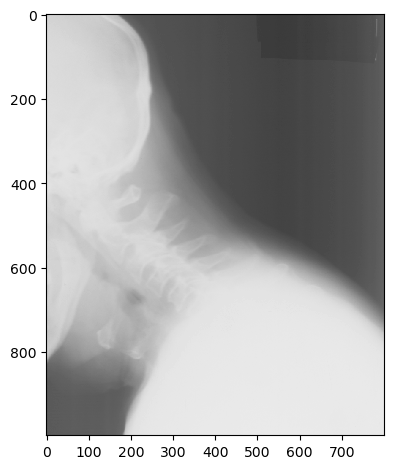

In [2]:
image = io.imread("data/vertebra.png")
io.imshow(image)

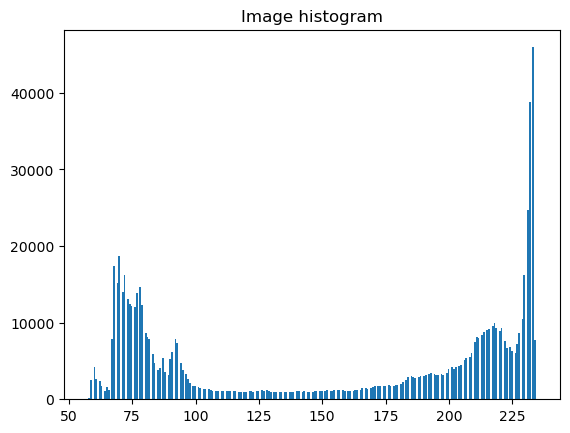

In [3]:
plt.hist(image.ravel(), bins=256)
plt.title('Image histogram')
io.show()

A bimodal histogram is a type of histogram that exhibits two distinct peaks or modes

**Exercise 2:** *Compute the minimum and maximum values of the image. Is the full scale of the gray-scale spectrum used or can we enhance the appearance of the image?*

The max number of pixel in a bin is 235.0
The max number of pixel in a bin is 57.0


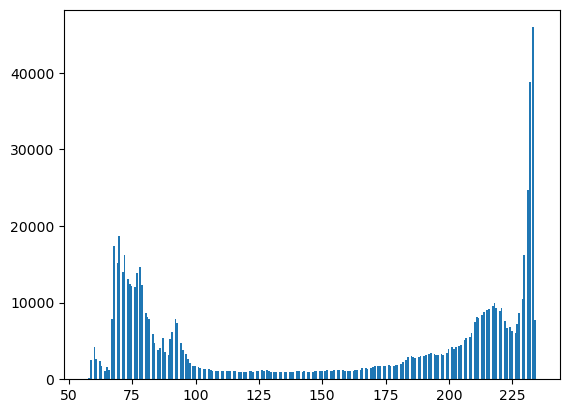

In [4]:
y, x, _ = plt.hist(image.ravel(), bins=256)
bin_min_range= np.min(x)
bin_max_range= np.max(x)
print(f"The max number of pixel in a bin is {bin_max_range}")
print(f"The max number of pixel in a bin is {bin_min_range}")

# Pixel type conversions

Before going further, we need to understand how to convert between between pixel types and what should be considered. A comphrehensive guide can be found [here](https://scikit-image.org/docs/stable/user_guide/data_types.html) (it is not mandatory reading, we just use some highlights). One important point is that we should avoid using the `astype` function on images. 

## Conversion from unsigned byte to float image

In *unsigned byte* images, the possible pixel value range is [0, 255]. When converting an *unsigned byte* image to a *float* image, the possible pixel value range will be [0, 1]. When you use Python skimage function `img_as_float` on an *unsigned byte* image, it will automatically divide all pixel values with 255.

**Exercise 3:** *Add an import statement to your script:*

In [5]:
# from skimage.util import img_as_float
# from skimage.util import img_as_ubyte


*Read the image `vertebra.png` and compute and show the minumum and maximum values.*

In [6]:
im_float = img_as_float(image)
bin_max_pixel= im_float.min()
bin_min_pixel= im_float.max()
print(f"The max number of pixel in a bin is {bin_max_pixel}")
print(f"The max number of pixel in a bin is {bin_min_pixel}")

The max number of pixel in a bin is 0.22352941176470587
The max number of pixel in a bin is 0.9215686274509803


*Use `img_as_float` to compute a new float version of your input image. Compute the minimum and maximum values of this float image. Can you verify that the float image is equal to the original image, where each pixel value is divided by 255?*

In [7]:
image_float = img_as_float(image)


The max number of pixel in a bin is 0.9215686274509803
The max number of pixel in a bin is 0.22352941176470587


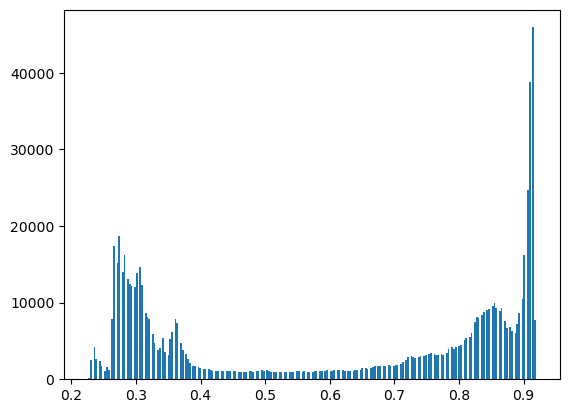

In [8]:
y, x, _ = plt.hist(image_float.ravel(), bins=256)
bin_min_range= np.min(x)
bin_max_range= np.max(x)
print(f"The max number of pixel in a bin is {bin_max_range}")
print(f"The max number of pixel in a bin is {bin_min_range}")

## Conversion from float image to unsigned byte image

As stated above, an (unsigned) float image can have pixel values in [0, 1]. When using the Python skimage function `img_as_ubyte` on an (unsigned) float image, it will multiply all values with 255 before converting into a byte. Remember that all decimal number will be converted into integers by this, and some information might be lost. **Exercise 4:** *Use `img_as_ubyte` on the float image you computed in the previous exercise. Compute the Compute the minimum and maximum values of this image. Are they as expected?*

The max number of pixel in a bin is 235.0
The max number of pixel in a bin is 57.0


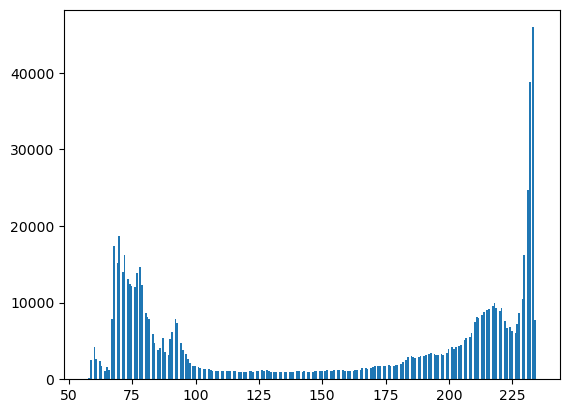

In [9]:
image_ubyte = img_as_ubyte(image_float)
y, x, _ = plt.hist(image_ubyte.ravel(), bins=256)
bin_min_range= np.min(x)
bin_max_range= np.max(x)
print(f"The max number of pixel in a bin is {bin_max_range}")
print(f"The max number of pixel in a bin is {bin_min_range}")

# Histogram stretching

You should implement a function, that automatically stretches the histogram of an image. In other words, the function should create a new image, where the pixel values are changed so the histogram of the output image is *optimal*. Here *optimal* means, that the minimum value is 0 and the maximum value is 255. It should be based on the *linear histogram stretching* equation:

$$g(x,y) =\frac{v_\text{max,d}-v_\text{min,d}}{v_\text{max}-v_\text{min}}(f(x,y) - v_\text{min} )+v_\text{min,d} \enspace .$$

Here $f(x,y)$ is the input pixel value and  $g(x,y)$ is the output pixel value, $v_\text{max,d}$ and $v_\text{min,d}$ are the desired minimum and maximum values (0 and 255) and  $v_\text{max}$ and $v_\text{min}$ are the current minumum and maximum values.

**Exercise 5:** *Implement a Python function called `histogram_stretch`. It can, for example, follow this example:*

In [10]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
    img_out = ((max_desired- min_desired)/(max_val - min_val))*(img_float-min_val) + min_desired
    # Do something here

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

**Exercise 6:** *Test your `histogram_stretch` on the `vertebra.png` image. Show the image before and after the histogram stretching. What changes do you notice in the image? Are the important structures more visible?*

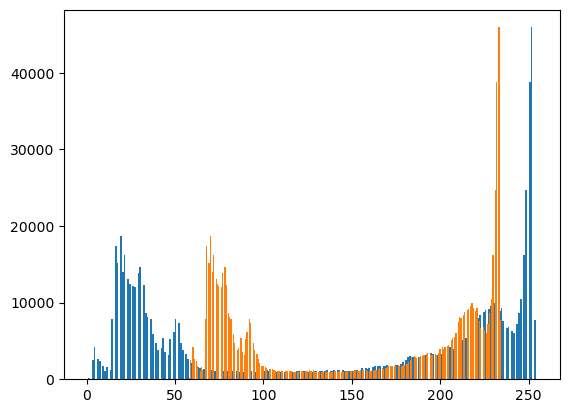

In [11]:
image_stretch =histogram_stretch(image)
y, x, _ = plt.hist(image_stretch.ravel(), bins=256)
y, x, _ = plt.hist(image.ravel(), bins=256)


# Non-linear pixel value mapping

The goal is to implement and test a function that performs a $\gamma$-mapping of pixel values:

$$g(x,y) = f(x,y)^\gamma \enspace .$$

You can use the *Numpy* function `power` to compute the actual mapping function. 

**Exercise 7:** *Implement a function, `gamma_map(img, gamma)`, that:1. Converts the input image to float
2. Do the gamma mapping on the pixel values
3. Returns the resulting image as an unsigned byte image.*

In [12]:
def gamma_map(img, gamma):
    img_float = img_as_float(img)
    img_gamma= np.power(img_float, gamma)
    return img_as_ubyte(img_gamma)
    

**Exercise 8:** *Test your `gamma_map` function on the vertebra image or another image of your choice. Try different values of* $\gamma$, *for example 0.5 and 2.0. Show the resuling image together with the input image. Can you see the differences in the images?*

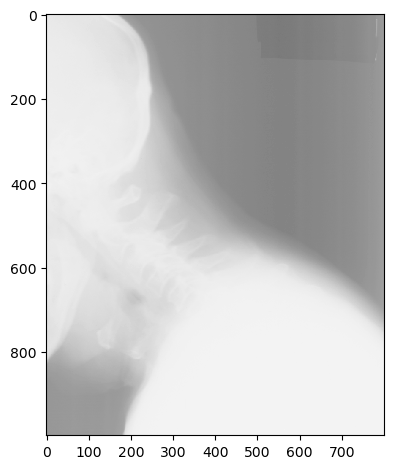

In [26]:
gamma_image= gamma_map(image, 0.5)
io.imshow(gamma_image)


Gamma less than 1: When the gamma value is less than 1, gamma correction decreases the brightness of the image and increases the contrast

When the gamma value is greater than 1, gamma correction increases the brightness of the image and decreases the contrast. 

# Image segmentation by thresholding

Now we will try to implement some functions that can seperate an image into *segments*. In this exercise, we aim at seperating the *background* from the *foreground* by setting a threshold in a gray scale image or several thresholds in color images.

**Exercise 9:** *Implement a function, `threshold_image` :*

In [14]:
def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """
    img_float = img_as_float(img_in)
    binary_image = img_float > thres
    
    return img_as_ubyte(binary_image)

**Exercise 10:** *Test your `threshold_image` function on the vertebra image with different thresholds. It is probably not possible to find a threshold that seperates the bones from the background, but can you find a threshold that seperates the human from the background?*

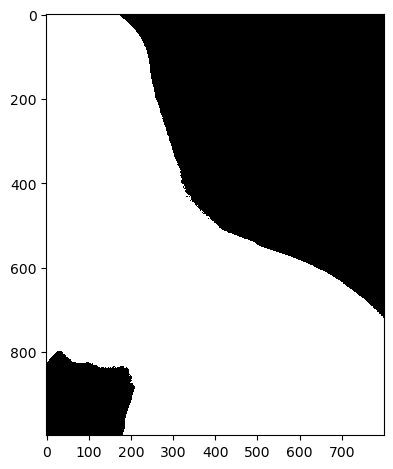

In [15]:
thres = threshold_image(image, 0.5)
io.imshow(thres)

## Automatic thresholds using Otsu's method

An optimal threshold can be estimated using [*Otsu's method*](https://en.wikipedia.org/wiki/Otsu%27s_method). This method finds the threshold, that minimizes the combined variance of the foreground and background.

**Exercise 11:** *Read the documentation of [Otsu's method](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu) and use it to compute and apply a threshold to the vertebra image.* Remember to import the method:

In [16]:
# from skimage.filters import threshold_otsu

def otsu(img):
    img_float = img_as_float(img)
    threshold_value = threshold_otsu(img_float)

    # Apply the threshold to the image
    img_thresholded = img_float >= threshold_value

    return img_as_ubyte(img_thresholded)

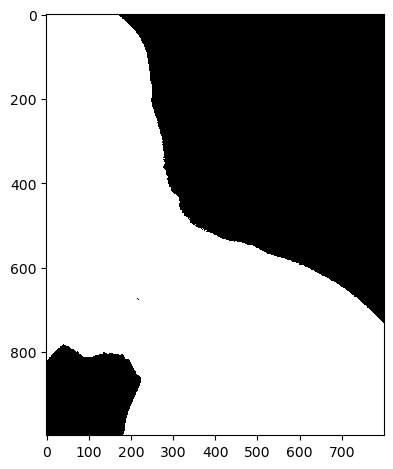

In [17]:
otsu_image = otsu(image)
io.imshow(otsu_image)

**Exercicse 12:** *Use your camera to take some pictures of yourself or a friend. Try to
take a picture on a dark background. Convert the image to grayscale
and try to find a threshold that creates a **silhouette** image (an image where the head is all white and the background black).*

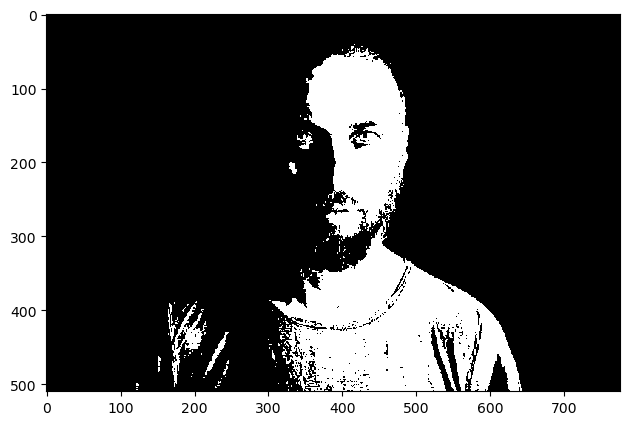

In [18]:
img_silhoutte= io.imread("data/dark_background.png")
image_to_gray= util.img_as_ubyte(rgb2gray(img_silhoutte))
img_silhoutte = otsu(image_to_gray)
io.imshow(img_silhoutte)

## Color thresholding in the RGB color space

In the following, we will make a simple system for road-sign detection. Start by reading the image **DTUSigns2.jpg** found in the [exercise data](https://github.com/RasmusRPaulsen/DTUImageAnalysis/blob/main/exercises/ex3-PixelwiseOperations/data/). We want to make a system that do a *segmentation* of the image - meaning that a new binary image is created, where the foreground pixels correspond to the sign we want to detect.

We do that by tresholding the colour-channels individually. This code segments out the blue sign:

In [19]:
im_org = io.imread("data/DTUSigns2.jpg")
r_comp = im_org[:, :, 0]
g_comp = im_org[:, :, 1]
b_comp = im_org[:, :, 2]
segm_blue = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
                (b_comp > 180) & (b_comp < 200)

print(segm_blue)
print(b_comp)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[ 42  39  39 ... 215 209 210]
 [ 42  46  44 ... 216 210 211]
 [ 45  44  42 ... 216 211 212]
 ...
 [128 147 187 ... 155 159 155]
 [126 155 210 ... 159 157 153]
 [120 178 215 ... 160 156 159]]


**Exercise 13:** *Create a function `detect_dtu_signs` that takes as input a color image and returns an image, where the blue sign is identified by foreground pixels.*

In [20]:
def detect_dtu_signs(im_org):
    r_comp = im_org[:, :, 0]
    g_comp = im_org[:, :, 1]
    b_comp = im_org[:, :, 2]
    segm_blue = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
                (b_comp > 180) & (b_comp < 200)
    img_blue = np.where(segm_blue, 255, 0)
    ubyte =img_as_ubyte(img_blue)
    

    return ubyte

c:\Users\Leuro\anaconda3\envs\Image_Analysis\Lib\site-packages\skimage\util\dtype.py:550: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


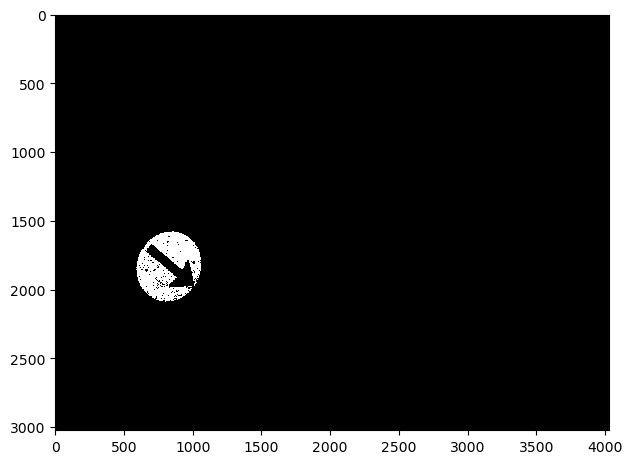

In [21]:
sign = detect_dtu_signs(im_org)
io.imshow(sign)

**Exercise 14:** *Extend your `detect_dtu_signs` function so it can also detect red signs. You can add an argument to the function, that tells which color it should look for. 
You should use one of the explorative image tools to find out what the typical RGB values are in the red signs.*

In [22]:
def detect_dtu_signs_color(im_org, color='red'):
    r_comp = im_org[:, :, 0]
    g_comp = im_org[:, :, 1]
    b_comp = im_org[:, :, 2]
    
    if color == 'blue':
        segm_color = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
                    (b_comp > 180) & (b_comp < 200)
    elif color == 'red':
        # Typical RGB values for red signs
        segm_color = (r_comp > 160) & (r_comp < 180) & (g_comp > 50) & (g_comp < 80) & \
                    (b_comp > 50) & (b_comp < 80)
    else:
        raise ValueError("Invalid color. Supported colors are 'blue' and 'red'.")
    
    ubyte = img_as_ubyte(segm_color)

    return ubyte

c:\Users\Leuro\anaconda3\envs\Image_Analysis\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


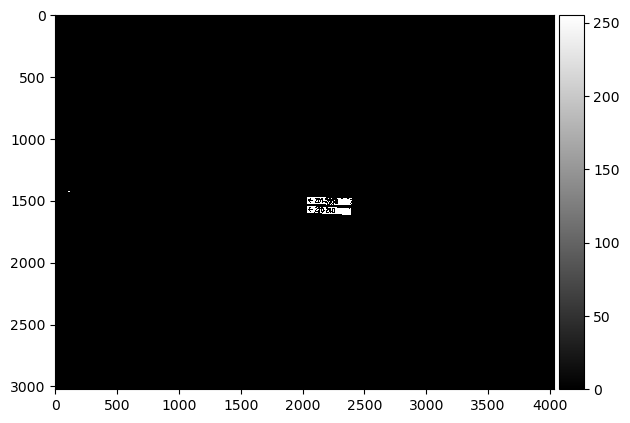

In [23]:
sign = detect_dtu_signs_color(im_org, 'red')
io.imshow(sign, cmap= 'gray')

## Color thresholding in the HSV color space

Sometimes it gives better segmentation results when the tresholding is done in HSI (also known as HSV - hue, saturation, value) space. Start by reading the  **DTUSigns2.jpg** image, convert it to HSV and show the hue and value (from [here](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_hsv.html)):

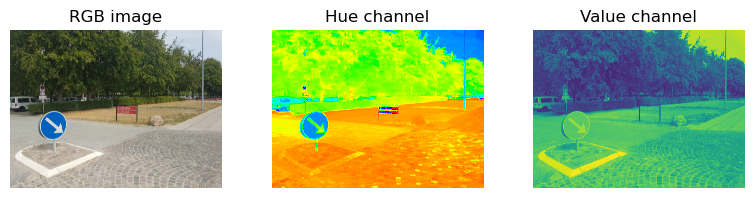

In [24]:
# import matplotlib.pyplot as plt

# from skimage import data
# from skimage.color import rgb2hsv
hsv_img = rgb2hsv(im_org)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))
ax0.imshow(im_org)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()
io.show()

**Exercise 15:** *Now make a sign segmentation function using tresholding in HSV space and locate both the blue and the red sign.*

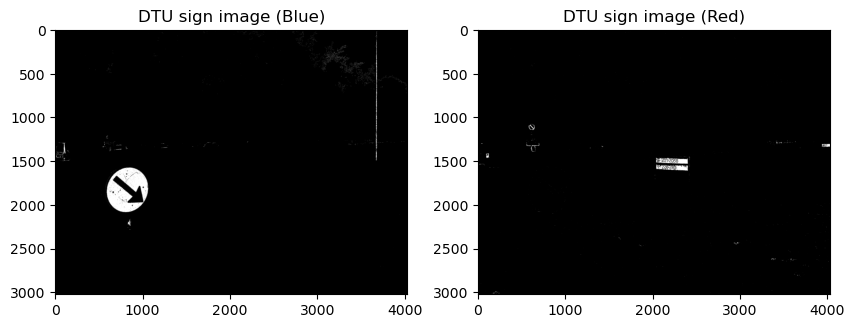

In [25]:
segm_blue = (hue_img < 0.6) & (hue_img  > 0.4) & (value_img < 0.77) & (value_img > 0.70)
segm_red = (hue_img < 1.0) & (hue_img  > 0.9)

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(segm_blue, cmap = 'gray')
ax1.set_title('DTU sign image (Blue)')

ax2.imshow(segm_red, cmap = 'gray')
ax2.set_title('DTU sign image (Red)')
plt.show()